Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Train: 14437, Val: 2073, Test: 4128
Using device: cuda
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 20.5M/20.5M [00:00<00:00, 112MB/s] 


Epoch 1/5, Train Loss: 0.8200, Val Loss: 0.4387, Val Acc: 0.8842
Epoch 2/5, Train Loss: 0.3960, Val Loss: 0.3196, Val Acc: 0.9137
Epoch 3/5, Train Loss: 0.3198, Val Loss: 0.2785, Val Acc: 0.9185
Epoch 4/5, Train Loss: 0.2852, Val Loss: 0.2552, Val Acc: 0.9305
Epoch 5/5, Train Loss: 0.2656, Val Loss: 0.2407, Val Acc: 0.9291

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot     0.9698    0.9650    0.9674       200
                     Pepper__bell___healthy     0.9641    0.9966    0.9801       296
                      Potato___Early_blight     0.9796    0.9600    0.9697       200
                       Potato___Late_blight     0.9104    0.9650    0.9369       200
                           Potato___healthy     0.9655    0.9333    0.9492        30
                      Tomato_Bacterial_spot     0.9458    0.9413    0.9435       426
                        Tomato_Early_blight     0.8421 

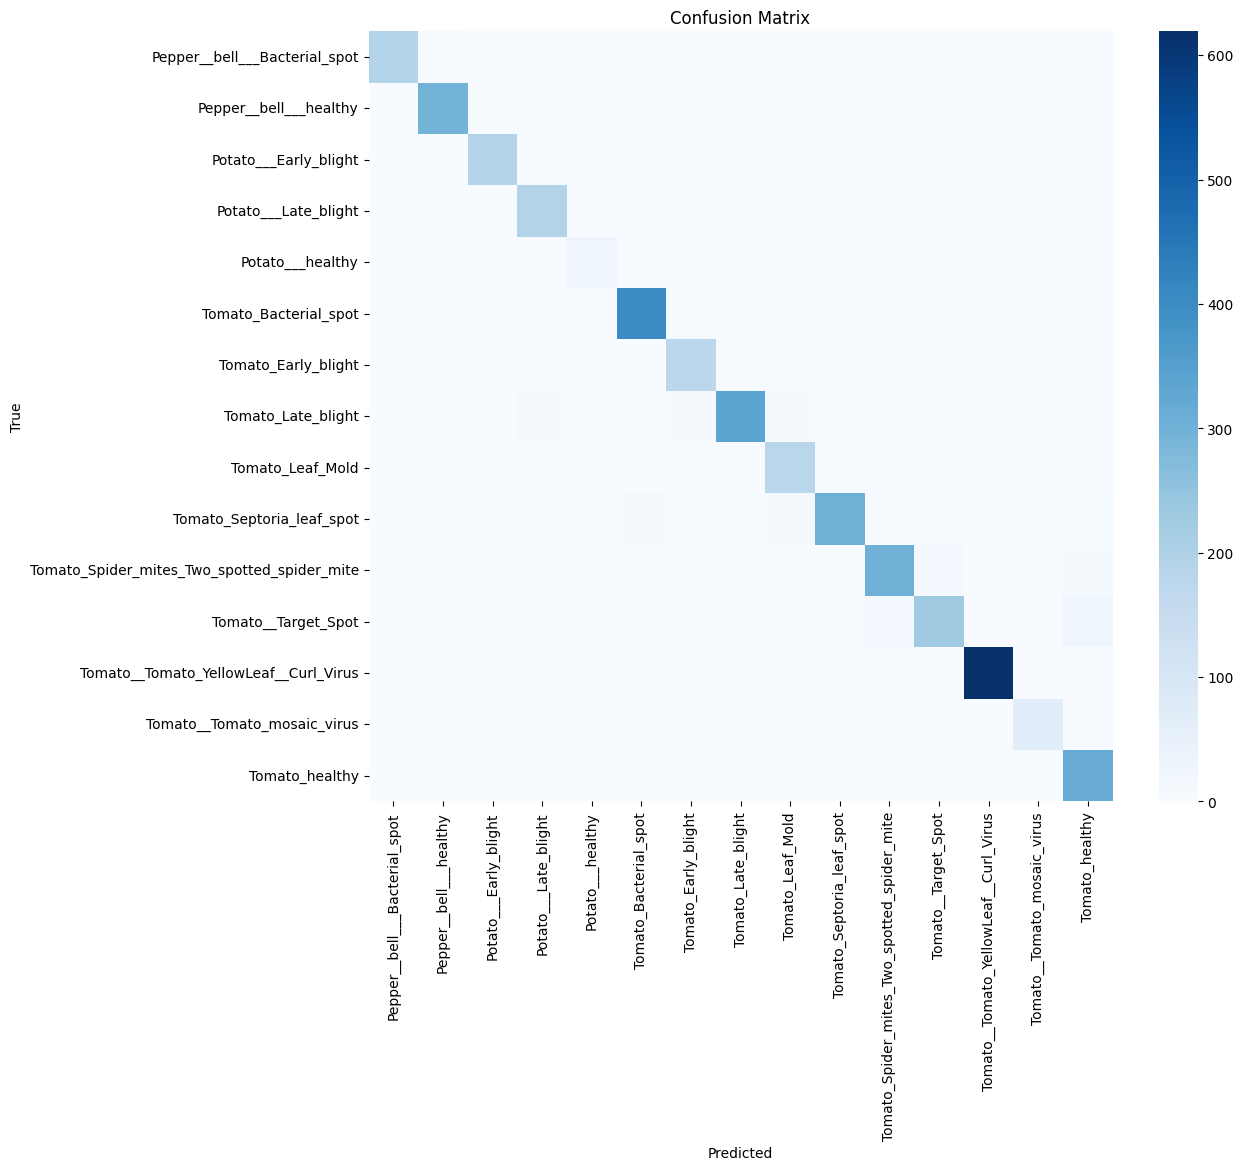

In [1]:
import os
import shutil
import random
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

# =========================================================
# STEP 1: Split dataset
# =========================================================
DATASET_DIR = "/content/drive/MyDrive/dataset_raw"
OUTPUT_DIR  = "/content/drive/MyDrive/dataset_split"

# =========================================================
# STEP 2: DataLoader
# =========================================================
IMG_SIZE = 224
BATCH_SIZE = 32

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(os.path.join(OUTPUT_DIR, "train"), transform=train_transforms)
val_dataset   = datasets.ImageFolder(os.path.join(OUTPUT_DIR, "val"), transform=test_transforms)
test_dataset  = datasets.ImageFolder(os.path.join(OUTPUT_DIR, "test"), transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

classes = train_dataset.classes
num_classes = len(classes)
print("Classes:", classes)
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

# =========================================================
# STEP 3: Model (EfficientNet-B0)
# =========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = models.efficientnet_b0(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# =========================================================
# STEP 4: Training function
# =========================================================
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=5):
    history = {"train_loss": [], "val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # validation
        model.eval()
        val_loss, correct = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels.data)

        val_loss /= len(val_loader.dataset)
        val_acc = correct.double() / len(val_loader.dataset)
        history["train_loss"].append(epoch_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc.item())

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return model, history

# Train model
model, history = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=5)

# =========================================================
# STEP 5: Evaluation on Test set
# =========================================================
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()